In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install tensorpack

%cd gdrive/MyDrive/SEAI_Project

     |████████████████████████████████| 296 kB 8.3 MB/s 
/content/gdrive/MyDrive/SEAI_backup


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# File: svhn-digit-dorefa.py
# Author: Yuxin Wu

import argparse
import os
import tensorflow as tf

from tensorpack import *
from tensorpack.dataflow import dataset
from tensorpack.tfutils.summary import add_moving_summary, add_param_summary
from tensorpack.tfutils.varreplace import remap_variables

"""
This is a tensorpack script for the SVHN results in paper:
DoReFa-Net: Training Low Bitwidth Convolutional Neural Networks with Low Bitwidth Gradients
http://arxiv.org/abs/1606.06160
The original experiements are performed on a proprietary framework.
This is our attempt to reproduce it on tensorpack.
Accuracy:
    With (W,A,G)=(1,1,4), can reach 3.1~3.2% error after 150 epochs.
    With (W,A,G)=(1,2,4), error is 3.0~3.1%.
    With (W,A,G)=(32,32,32), error is about 2.3%.
Speed:
    With quantization, 60 batch/s on 1 1080Ti. (4721 batch / epoch)
To Run:
    ./svhn-digit-dorefa.py --dorefa 1,2,4
"""
tf.compat.v1.reset_default_graph()

BITW = 1
BITA = 6
BITG = 4

"""
imported from dorefa file
"""
def get_dorefa(bitW, bitA, bitG):
    """
    Return the three quantization functions fw, fa, fg, for weights, activations and gradients respectively
    """
    def quantize(x, k):
        n = float(2 ** k - 1)

        @tf.custom_gradient
        def _quantize(x):
            return tf.round(x * n) / n, lambda dy: dy

        return _quantize(x)

    def fw(x):
        if bitW == 32:
            return x

        if bitW == 1:   # BWN
            E = tf.stop_gradient(tf.reduce_mean(tf.abs(x)))

            @tf.custom_gradient
            def _sign(x):
                return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sign(x / E)) * E, lambda dy: dy

            return _sign(x)

        x = tf.tanh(x)
        x = x / tf.reduce_max(tf.abs(x)) * 0.5 + 0.5
        return 2 * quantize(x, bitW) - 1

    def fa(x):
        if bitA == 32:
            return x
        return quantize(x, bitA)

    def fg(x):
        if bitG == 32:
            return x

        @tf.custom_gradient
        def _identity(input):
            def grad_fg(x):
                rank = x.get_shape().ndims
                assert rank is not None
                maxx = tf.reduce_max(tf.abs(x), list(range(1, rank)), keepdims=True)
                x = x / maxx
                n = float(2**bitG - 1)
                x = x * 0.5 + 0.5 + tf.random.uniform(
                    tf.shape(x), minval=-0.5 / n, maxval=0.5 / n)
                x = tf.clip_by_value(x, 0.0, 1.0)
                x = quantize(x, bitG) - 0.5
                return x * maxx * 2

            return input, grad_fg

        return _identity(x)
    return fw, fa, fg


class Model(ModelDesc):
    def inputs(self):
        return [tf.TensorSpec([None, 40, 40], tf.float32, 'input'),
                tf.TensorSpec([None], tf.int32, 'label')]

    def build_graph(self, image, label):
        fw, fa, fg = get_dorefa(BITW, BITA, BITG)

        # monkey-patch tf.get_variable to apply fw
        def binarize_weight(v):
            name = v.op.name
            # don't binarize first and last layer
            
            if not name.endswith('W'):
                return v
            else:
                logger.info("Binarizing weight {}".format(v.op.name))
                return fw(v)

        def nonlin(x):
            if BITA == 32:
                return tf.nn.relu(x)
            return tf.clip_by_value(x, 0.0, 1.0)

        def activate(x):
            return fa(nonlin(x))

        image = tf.expand_dims(image, 3)
        image = image / 256.0

        with remap_variables(binarize_weight), \
                argscope(BatchNorm, momentum=0.9, epsilon=1e-4), \
                argscope(Conv2D, use_bias=False):
            logits = (LinearWrap(image)
                      .Conv2D('conv0', 48, 5, padding='VALID', use_bias=True)
                      .AvgPooling('pool0', 2, padding='SAME')
                      .apply(activate)
                      # 18
                      .Conv2D('conv1', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn1').apply(activate)
#AVGPooling
                      .Conv2D('conv2', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn2')
                      .AvgPooling('pool1', 2, padding='SAME')
                      .apply(activate)
                      # 9
                      .Conv2D('conv3', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn3').apply(activate)
                      # 7

                      .Conv2D('conv4', 128, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn4').apply(activate)

                      .Conv2D('conv5', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn5').apply(activate)
                      # 5
                      .Dropout(rate=0.5 if self.training else 0.0)
                      .Conv2D('conv6', 512, 5, padding='VALID')
                      .apply(fg).BatchNorm('bn6')
                      .apply(nonlin)
                      .FullyConnected('fc1', 10)())
        tf.nn.softmax(logits, name='output')

        correct = tf.cast(tf.nn.in_top_k(predictions=logits, targets=label, k=1), tf.float32, name='correct')
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        summary.add_moving_summary(train_error, accuracy)
        
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')
        # weight decay on all W of fc layers
        wd_cost = regularize_cost('fc.*/W', l2_regularizer(1e-7))
        add_param_summary(('.*/W', ['histogram', 'rms']))
        total_cost = tf.add_n([cost, wd_cost], name='cost')
        add_moving_summary(cost, wd_cost, total_cost)
        return total_cost

    def optimizer(self):
        lr = tf.compat.v1.train.exponential_decay(
            learning_rate=1e-3,
            global_step=get_global_step_var(),
            decay_steps=4721 * 100,
            decay_rate=0.5, staircase=True, name='learning_rate')
        tf.summary.scalar('lr', lr)

        return tf.compat.v1.train.AdamOptimizer(lr, epsilon=1e-5)


def get_config():
    logger.set_logger_dir(os.path.join('train_log', 'mnist-dorefa-{}'.format(args)))

    # prepare dataset
    data_train = dataset.Mnist('train', shuffle=True)
    data_test = dataset.Mnist('test', shuffle=True)

    augmentors = [imgaug.Resize((40, 40))]
    data_train = AugmentImageComponent(data_train, augmentors)
    data_train = BatchData(data_train, 128)
    data_train = MultiProcessRunnerZMQ(data_train, 5)

    augmentors = [imgaug.Resize((40, 40))]
    data_test = AugmentImageComponent(data_test, augmentors)
    data_test = BatchData(data_test, 128, remainder=True)

    return TrainConfig(
        data=QueueInput(data_train),
        callbacks=[
            ModelSaver(),
            InferenceRunner(    # run inference(for validation) after every epoch
                data_test,   # the DataFlow instance used for validation
                ScalarStats(    # produce `val_accuracy` and `val_cross_entropy_loss`
                    ['cross_entropy_loss', 'accuracy'], prefix='val'))
        ],
        model=Model(),
        max_epoch=10,
    )

args = "1,6,4"
BITW, BITA, BITG = map(int, args.split(','))
config = get_config()
launch_train_with_config(config, SimpleTrainer())

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dorefa',
                        help='number of bits for W,A,G, separated by comma. Defaults to \'1,2,4\'',
                        default='1,2,4')
    args = parser.parse_args()

    BITW, BITA, BITG = map(int, args.dorefa.split(','))
    config = get_config()
    launch_train_with_config(config, SimpleTrainer())
'''

[0721 14:54:38 @logger.py:128] WRN Log directory train_log/mnist-dorefa-1,6,4 exists! Use 'd' to delete it. 
[0721 14:54:38 @logger.py:131] WRN If you're resuming from a previous run, you can choose to keep it.
Press any other key to exit. 
Select Action: k (keep) / d (delete) / q (quit):k
[0721 14:54:40 @logger.py:85] Existing log file 'train_log/mnist-dorefa-1,6,4/log.log' backuped to 'train_log/mnist-dorefa-1,6,4/log.log.0721-145440'
[0721 14:54:40 @logger.py:92] Argv: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-ee5999bb-92e7-4102-9041-c83b936a04e3.json
[0721 14:54:40 @fs.py:101] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[0721 14:54:40 @fs.py:104] Created the directory /root/tensorpack_data.
[0721 14:54:40 @mnist.py:21] Downloading to /root/tensorpack_data/mnist_data/train-images-idx3-ubyte.gz...


train-images-idx3-ubyte.gz: 9.92MB [05:03, 32.7kB/s]

[0721 14:59:44 @fs.py:73] Succesfully downloaded train-images-idx3-ubyte.gz. 9912422 bytes.


[0721 14:59:44 @mnist.py:21] Downloading to /root/tensorpack_data/mnist_data/train-labels-idx1-ubyte.gz...


train-labels-idx1-ubyte.gz: 32.8kB [00:00, 129kB/s]                             

[0721 14:59:44 @fs.py:73] Succesfully downloaded train-labels-idx1-ubyte.gz. 28881 bytes.
[0721 14:59:44 @mnist.py:21] Downloading to /root/tensorpack_data/mnist_data/t10k-images-idx3-ubyte.gz...



t10k-images-idx3-ubyte.gz: 1.65MB [00:51, 32.2kB/s]

[0721 15:00:36 @fs.py:73] Succesfully downloaded t10k-images-idx3-ubyte.gz. 1648877 bytes.
[0721 15:00:36 @mnist.py:21] Downloading to /root/tensorpack_data/mnist_data/t10k-labels-idx1-ubyte.gz...



t10k-labels-idx1-ubyte.gz: 8.19kB [00:00, 43.3kB/s]

[0721 15:00:36 @fs.py:73] Succesfully downloaded t10k-labels-idx1-ubyte.gz. 4542 bytes.
[0721 15:00:36 @parallel.py:340] [MultiProcessRunnerZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0721 15:00:36 @input_source.py:221] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0721 15:00:36 @trainers.py:48] Building graph for a single training tower ...
[0721 15:00:36 @<ipython-input-3-189c3a653236>:114] Binarizing weight conv0/W
[0721 15:00:36 @registry.py:90] 'conv0': [?, 40, 40, 1] --> [?, 36, 36, 48]
[0721 15:00:36 @registry.py:90] 'pool0': [?, 36, 36, 48] --> [?, 18, 18, 48]
[0721 15:00:36 @<ipython-input-3-189c3a653236>:114] Binarizing weight conv1/W
[0721 15:00:36 @registry.py:90] 'conv1': [?, 18, 18, 48] --> [?, 18, 18, 64]
[0721 15:00:36 @<ipython-input-3-189c3a653236>:114] Binarizing weight conv2/W
[0721 15:00:36 @registry.py:90] 'conv2': [?, 18, 18, 64] --> [?, 18, 18, 64]



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[0721 15:00:36 @registry.py:90] 'pool1': [?, 18, 18, 64] --> [?, 9, 9, 64]
[0721 15:00:36 @<ipython-input-3-189c3a653236>:114] Binarizing weight conv3/W
[0721 15:00:36 @registry.py:90] 'conv3': [?, 9, 9, 64] --> [?, 7, 7, 128]
[0721 15:00:36 @<ipython-input-3-189c3a653236>:114] Binarizing weight conv4/W
[0721 15:00:36 @registry.py:90] 'conv4': [?, 7, 7, 128] --> [?, 7, 7, 128]
[0721 15:00:37 @<ipython-input-3-189c3a653236>:114] Binarizing weight conv5/W
[0721 15:00:37 @registry.py:90] 'conv5': [?, 7, 7, 128] --> [?, 5, 5, 128]
[0721 15:00:37 @<ipython-input-3-189c3a653236>:114] Binarizing weight conv6/W
[0721 15:00:37 @registry.py:90] 'conv6': [?, 5, 5, 128] --> [?, 1, 1, 512]
[0721 15:00:37 @<ipython-input-3-189c3a653236>:114] Binarizing weight fc1/W
[0721 15:00:37 @registry.py:90] 'fc1': [?, 1, 1, 512] --> [?, 10]
[0721 15:00:37 @regularize.py:97] regularize_cost() found 1 variables to regularize.
[0721 15:00:37 @regularize.py:21] The following tensors will be regularized: fc1/W:0
[0

100%|##########|468/468[00:46<00:00,10.13it/s]

[0721 15:01:32 @base.py:283] Epoch 1 (global_step 468) finished, time:46.2 seconds.
[0721 15:01:32 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-468.



100%|##########|79/79[00:01<00:00,75.31it/s]

[0721 15:01:33 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:01:33 @monitor.py:476] accuracy: 0.97318
[0721 15:01:33 @monitor.py:476] cost: 0.088237
[0721 15:01:33 @monitor.py:476] cross_entropy_loss: 0.088235
[0721 15:01:33 @monitor.py:476] param-summary/conv0/W-rms: 0.27429
[0721 15:01:33 @monitor.py:476] param-summary/conv1/W-rms: 0.069178
[0721 15:01:33 @monitor.py:476] param-summary/conv2/W-rms: 0.05991
[0721 15:01:33 @monitor.py:476] param-summary/conv3/W-rms: 0.060488
[0721 15:01:33 @monitor.py:476] param-summary/conv4/W-rms: 0.044073
[0721 15:01:33 @monitor.py:476] param-summary/conv5/W-rms: 0.044825
[0721 15:01:33 @monitor.py:476] param-summary/conv6/W-rms: 0.028899
[0721 15:01:33 @monitor.py:476] param-summary/fc1/W-rms: 0.080328
[0721 15:01:33 @monitor.py:476] regularize_cost: 1.6351e-06
[0721 15:01:33 @monitor.py:476] train_error: 0.026822
[0721 15:01:33 @monitor.py:476] val_accuracy: 0.97409
[0721 15:01:33 @monitor.py:476] val_cross_entropy_loss: 0.0785
[0721 15:01:3


100%|##########|468/468[00:11<00:00,41.02it/s]

[0721 15:01:45 @base.py:283] Epoch 2 (global_step 936) finished, time:11.4 seconds.
[0721 15:01:45 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-936.



100%|##########|79/79[00:00<00:00,92.22it/s]

[0721 15:01:46 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:01:46 @monitor.py:476] accuracy: 0.98043
[0721 15:01:46 @monitor.py:476] cost: 0.056619
[0721 15:01:46 @monitor.py:476] cross_entropy_loss: 0.056617
[0721 15:01:46 @monitor.py:476] param-summary/conv0/W-rms: 0.27438
[0721 15:01:46 @monitor.py:476] param-summary/conv1/W-rms: 0.070002
[0721 15:01:46 @monitor.py:476] param-summary/conv2/W-rms: 0.060948
[0721 15:01:46 @monitor.py:476] param-summary/conv3/W-rms: 0.061701
[0721 15:01:46 @monitor.py:476] param-summary/conv4/W-rms: 0.045834
[0721 15:01:46 @monitor.py:476] param-summary/conv5/W-rms: 0.047118
[0721 15:01:46 @monitor.py:476] param-summary/conv6/W-rms: 0.031575
[0721 15:01:46 @monitor.py:476] param-summary/fc1/W-rms: 0.087069
[0721 15:01:46 @monitor.py:476] regularize_cost: 1.9307e-06
[0721 15:01:46 @monitor.py:476] train_error: 0.019575
[0721 15:01:46 @monitor.py:476] val_accuracy: 0.98566
[0721 15:01:46 @monitor.py:476] val_cross_entropy_loss: 0.043849
[0721 15:0


100%|##########|468/468[00:11<00:00,39.66it/s]

[0721 15:01:58 @base.py:283] Epoch 3 (global_step 1404) finished, time:11.8 seconds.
[0721 15:01:58 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-1404.



100%|##########|79/79[00:00<00:00,91.28it/s]

[0721 15:01:59 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:01:59 @monitor.py:476] accuracy: 0.98375
[0721 15:01:59 @monitor.py:476] cost: 0.053563
[0721 15:01:59 @monitor.py:476] cross_entropy_loss: 0.053561
[0721 15:01:59 @monitor.py:476] param-summary/conv0/W-rms: 0.27452
[0721 15:01:59 @monitor.py:476] param-summary/conv1/W-rms: 0.071141
[0721 15:01:59 @monitor.py:476] param-summary/conv2/W-rms: 0.062037
[0721 15:01:59 @monitor.py:476] param-summary/conv3/W-rms: 0.062939
[0721 15:01:59 @monitor.py:476] param-summary/conv4/W-rms: 0.047552
[0721 15:01:59 @monitor.py:476] param-summary/conv5/W-rms: 0.049297
[0721 15:01:59 @monitor.py:476] param-summary/conv6/W-rms: 0.034128
[0721 15:01:59 @monitor.py:476] param-summary/fc1/W-rms: 0.092388
[0721 15:01:59 @monitor.py:476] regularize_cost: 2.1793e-06
[0721 15:01:59 @monitor.py:476] train_error: 0.01625
[0721 15:01:59 @monitor.py:476] val_accuracy: 0.98922
[0721 15:01:59 @monitor.py:476] val_cross_entropy_loss: 0.037151
[0721 15:01


100%|##########|468/468[00:11<00:00,39.57it/s]

[0721 15:02:10 @base.py:283] Epoch 4 (global_step 1872) finished, time:11.8 seconds.
[0721 15:02:10 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-1872.



100%|##########|79/79[00:00<00:00,88.55it/s]

[0721 15:02:11 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:02:11 @monitor.py:476] accuracy: 0.98298
[0721 15:02:11 @monitor.py:476] cost: 0.046282
[0721 15:02:11 @monitor.py:476] cross_entropy_loss: 0.04628
[0721 15:02:11 @monitor.py:476] param-summary/conv0/W-rms: 0.27508
[0721 15:02:11 @monitor.py:476] param-summary/conv1/W-rms: 0.071981
[0721 15:02:11 @monitor.py:476] param-summary/conv2/W-rms: 0.063234
[0721 15:02:11 @monitor.py:476] param-summary/conv3/W-rms: 0.064222
[0721 15:02:11 @monitor.py:476] param-summary/conv4/W-rms: 0.049115
[0721 15:02:11 @monitor.py:476] param-summary/conv5/W-rms: 0.051452
[0721 15:02:11 @monitor.py:476] param-summary/conv6/W-rms: 0.036582
[0721 15:02:11 @monitor.py:476] param-summary/fc1/W-rms: 0.097216
[0721 15:02:11 @monitor.py:476] regularize_cost: 2.411e-06
[0721 15:02:11 @monitor.py:476] train_error: 0.017022
[0721 15:02:11 @monitor.py:476] val_accuracy: 0.9731
[0721 15:02:11 @monitor.py:476] val_cross_entropy_loss: 0.085665
[0721 15:02:1


100%|##########|468/468[00:12<00:00,38.85it/s]

[0721 15:02:24 @base.py:283] Epoch 5 (global_step 2340) finished, time:12 seconds.
[0721 15:02:24 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-2340.



100%|##########|79/79[00:00<00:00,88.50it/s]

[0721 15:02:25 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:02:25 @monitor.py:476] accuracy: 0.98968
[0721 15:02:25 @monitor.py:476] cost: 0.031678
[0721 15:02:25 @monitor.py:476] cross_entropy_loss: 0.031676
[0721 15:02:25 @monitor.py:476] param-summary/conv0/W-rms: 0.27569
[0721 15:02:25 @monitor.py:476] param-summary/conv1/W-rms: 0.072717
[0721 15:02:25 @monitor.py:476] param-summary/conv2/W-rms: 0.064375
[0721 15:02:25 @monitor.py:476] param-summary/conv3/W-rms: 0.065578
[0721 15:02:25 @monitor.py:476] param-summary/conv4/W-rms: 0.050765
[0721 15:02:25 @monitor.py:476] param-summary/conv5/W-rms: 0.05363
[0721 15:02:25 @monitor.py:476] param-summary/conv6/W-rms: 0.039039
[0721 15:02:25 @monitor.py:476] param-summary/fc1/W-rms: 0.10159
[0721 15:02:25 @monitor.py:476] regularize_cost: 2.6284e-06
[0721 15:02:25 @monitor.py:476] train_error: 0.010317
[0721 15:02:25 @monitor.py:476] val_accuracy: 0.98991
[0721 15:02:25 @monitor.py:476] val_cross_entropy_loss: 0.02959
[0721 15:02:2


100%|##########|468/468[00:11<00:00,40.31it/s]

[0721 15:02:36 @base.py:283] Epoch 6 (global_step 2808) finished, time:11.6 seconds.
[0721 15:02:36 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-2808.



100%|##########|79/79[00:00<00:00,91.58it/s]

[0721 15:02:37 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:02:37 @monitor.py:476] accuracy: 0.98852
[0721 15:02:37 @monitor.py:476] cost: 0.037618
[0721 15:02:37 @monitor.py:476] cross_entropy_loss: 0.037615
[0721 15:02:37 @monitor.py:476] param-summary/conv0/W-rms: 0.27621
[0721 15:02:37 @monitor.py:476] param-summary/conv1/W-rms: 0.073525
[0721 15:02:37 @monitor.py:476] param-summary/conv2/W-rms: 0.06546
[0721 15:02:37 @monitor.py:476] param-summary/conv3/W-rms: 0.067019
[0721 15:02:37 @monitor.py:476] param-summary/conv4/W-rms: 0.052458
[0721 15:02:37 @monitor.py:476] param-summary/conv5/W-rms: 0.05569
[0721 15:02:37 @monitor.py:476] param-summary/conv6/W-rms: 0.041484
[0721 15:02:37 @monitor.py:476] param-summary/fc1/W-rms: 0.10596
[0721 15:02:37 @monitor.py:476] regularize_cost: 2.8697e-06
[0721 15:02:37 @monitor.py:476] train_error: 0.011481
[0721 15:02:37 @monitor.py:476] val_accuracy: 0.98794
[0721 15:02:37 @monitor.py:476] val_cross_entropy_loss: 0.033661
[0721 15:02:3


100%|##########|468/468[00:11<00:00,39.26it/s]

[0721 15:02:49 @base.py:283] Epoch 7 (global_step 3276) finished, time:11.9 seconds.
[0721 15:02:49 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-3276.



100%|##########|79/79[00:00<00:00,90.54it/s]

[0721 15:02:50 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:02:50 @monitor.py:476] accuracy: 0.98479
[0721 15:02:50 @monitor.py:476] cost: 0.049096
[0721 15:02:50 @monitor.py:476] cross_entropy_loss: 0.049093
[0721 15:02:50 @monitor.py:476] param-summary/conv0/W-rms: 0.27726
[0721 15:02:50 @monitor.py:476] param-summary/conv1/W-rms: 0.074321
[0721 15:02:50 @monitor.py:476] param-summary/conv2/W-rms: 0.066926
[0721 15:02:50 @monitor.py:476] param-summary/conv3/W-rms: 0.068647
[0721 15:02:50 @monitor.py:476] param-summary/conv4/W-rms: 0.054345
[0721 15:02:50 @monitor.py:476] param-summary/conv5/W-rms: 0.05795
[0721 15:02:50 @monitor.py:476] param-summary/conv6/W-rms: 0.044096
[0721 15:02:50 @monitor.py:476] param-summary/fc1/W-rms: 0.10996
[0721 15:02:50 @monitor.py:476] regularize_cost: 3.0921e-06
[0721 15:02:50 @monitor.py:476] train_error: 0.015215
[0721 15:02:50 @monitor.py:476] val_accuracy: 0.98705
[0721 15:02:50 @monitor.py:476] val_cross_entropy_loss: 0.0391
[0721 15:02:50


100%|##########|468/468[00:11<00:00,39.61it/s]

[0721 15:03:02 @base.py:283] Epoch 8 (global_step 3744) finished, time:11.8 seconds.
[0721 15:03:02 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-3744.



100%|##########|79/79[00:00<00:00,91.32it/s]

[0721 15:03:03 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:03:03 @monitor.py:476] accuracy: 0.9882
[0721 15:03:03 @monitor.py:476] cost: 0.038737
[0721 15:03:03 @monitor.py:476] cross_entropy_loss: 0.038734
[0721 15:03:03 @monitor.py:476] param-summary/conv0/W-rms: 0.28012
[0721 15:03:03 @monitor.py:476] param-summary/conv1/W-rms: 0.075461
[0721 15:03:03 @monitor.py:476] param-summary/conv2/W-rms: 0.068421
[0721 15:03:03 @monitor.py:476] param-summary/conv3/W-rms: 0.070444
[0721 15:03:03 @monitor.py:476] param-summary/conv4/W-rms: 0.056571
[0721 15:03:03 @monitor.py:476] param-summary/conv5/W-rms: 0.060412
[0721 15:03:03 @monitor.py:476] param-summary/conv6/W-rms: 0.047015
[0721 15:03:03 @monitor.py:476] param-summary/fc1/W-rms: 0.1141
[0721 15:03:03 @monitor.py:476] regularize_cost: 3.3267e-06
[0721 15:03:03 @monitor.py:476] train_error: 0.011803
[0721 15:03:03 @monitor.py:476] val_accuracy: 0.99001
[0721 15:03:03 @monitor.py:476] val_cross_entropy_loss: 0.030988
[0721 15:03:0


100%|##########|468/468[00:12<00:00,38.71it/s]

[0721 15:03:15 @base.py:283] Epoch 9 (global_step 4212) finished, time:12.1 seconds.
[0721 15:03:15 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-4212.



100%|##########|79/79[00:00<00:00,88.03it/s]

[0721 15:03:16 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:03:16 @monitor.py:476] accuracy: 0.99033
[0721 15:03:16 @monitor.py:476] cost: 0.027924
[0721 15:03:16 @monitor.py:476] cross_entropy_loss: 0.027921
[0721 15:03:16 @monitor.py:476] param-summary/conv0/W-rms: 0.28444
[0721 15:03:16 @monitor.py:476] param-summary/conv1/W-rms: 0.076793
[0721 15:03:16 @monitor.py:476] param-summary/conv2/W-rms: 0.070184
[0721 15:03:16 @monitor.py:476] param-summary/conv3/W-rms: 0.072202
[0721 15:03:16 @monitor.py:476] param-summary/conv4/W-rms: 0.058542
[0721 15:03:16 @monitor.py:476] param-summary/conv5/W-rms: 0.062673
[0721 15:03:16 @monitor.py:476] param-summary/conv6/W-rms: 0.049586
[0721 15:03:16 @monitor.py:476] param-summary/fc1/W-rms: 0.11824
[0721 15:03:16 @monitor.py:476] regularize_cost: 3.5684e-06
[0721 15:03:16 @monitor.py:476] train_error: 0.0096722
[0721 15:03:16 @monitor.py:476] val_accuracy: 0.98833
[0721 15:03:16 @monitor.py:476] val_cross_entropy_loss: 0.041051
[0721 15:0


100%|##########|468/468[00:11<00:00,39.49it/s]

[0721 15:03:28 @base.py:283] Epoch 10 (global_step 4680) finished, time:11.9 seconds.
[0721 15:03:28 @saver.py:82] Model saved to train_log/mnist-dorefa-1,6,4/model-4680.



100%|##########|79/79[00:00<00:00,87.72it/s]

[0721 15:03:29 @monitor.py:476] QueueInput/queue_size: 50
[0721 15:03:29 @monitor.py:476] accuracy: 0.98975
[0721 15:03:29 @monitor.py:476] cost: 0.033044
[0721 15:03:29 @monitor.py:476] cross_entropy_loss: 0.03304
[0721 15:03:29 @monitor.py:476] param-summary/conv0/W-rms: 0.28638
[0721 15:03:29 @monitor.py:476] param-summary/conv1/W-rms: 0.078198
[0721 15:03:29 @monitor.py:476] param-summary/conv2/W-rms: 0.071538
[0721 15:03:29 @monitor.py:476] param-summary/conv3/W-rms: 0.073696
[0721 15:03:29 @monitor.py:476] param-summary/conv4/W-rms: 0.060632
[0721 15:03:29 @monitor.py:476] param-summary/conv5/W-rms: 0.064798
[0721 15:03:29 @monitor.py:476] param-summary/conv6/W-rms: 0.052048
[0721 15:03:29 @monitor.py:476] param-summary/fc1/W-rms: 0.12233
[0721 15:03:29 @monitor.py:476] regularize_cost: 3.8208e-06
[0721 15:03:29 @monitor.py:476] train_error: 0.010246
[0721 15:03:29 @monitor.py:476] val_accuracy: 0.98962
[0721 15:03:29 @monitor.py:476] val_cross_entropy_loss: 0.034762
[0721 15:03:

"\nif __name__ == '__main__':\n    parser = argparse.ArgumentParser()\n    parser.add_argument('--dorefa',\n                        help='number of bits for W,A,G, separated by comma. Defaults to '1,2,4'',\n                        default='1,2,4')\n    args = parser.parse_args()\n\n    BITW, BITA, BITG = map(int, args.dorefa.split(','))\n    config = get_config()\n    launch_train_with_config(config, SimpleTrainer())\n"

<Figure size 432x288 with 0 Axes>

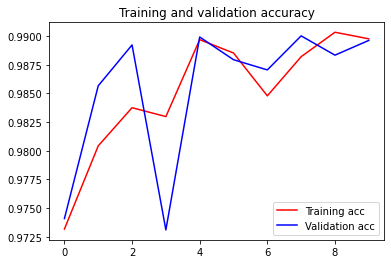

<Figure size 432x288 with 0 Axes>

In [ ]:
import json
import matplotlib.pyplot as plt

f = open("train_log/mnist-dorefa-1,6,4/stats.json","r")

data = json.load(f)
accuracy = []
val_accuracy = []
for ob in data:
  accuracy.append(ob["accuracy"])
  val_accuracy.append(ob["val_accuracy"])

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt

ep = [i+1 for i in epochs]
table_acc = {"Epochs" : ep, "Accuracy":accuracy}
table_val_acc = {"Epochs" : ep, "Accuracy":val_accuracy}

print("ACCURACY\n")
print(tabulate(table_acc, headers='keys', tablefmt='fancy_grid'))
print("\nVALIDATION ACCURACY\n")
print(tabulate(table_val_acc, headers='keys', tablefmt='fancy_grid'))

ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.973178 │
├──────────┼────────────┤
│        2 │   0.980425 │
├──────────┼────────────┤
│        3 │   0.98375  │
├──────────┼────────────┤
│        4 │   0.982978 │
├──────────┼────────────┤
│        5 │   0.989683 │
├──────────┼────────────┤
│        6 │   0.988519 │
├──────────┼────────────┤
│        7 │   0.984785 │
├──────────┼────────────┤
│        8 │   0.988197 │
├──────────┼────────────┤
│        9 │   0.990328 │
├──────────┼────────────┤
│       10 │   0.989754 │
╘══════════╧════════════╛

VALIDATION ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.97409  │
├──────────┼────────────┤
│        2 │   0.985661 │
├──────────┼────────────┤
│        3 │   0.989221 │
├──────────┼────────────┤
│        4 │   0.973101 │
├──────────┼────────────┤
│        5 │   0.989913 │
├──────────┼────────────┤
│        6 │   0.987935 │
├─────